# ResNet-50 for Cats.Vs.Dogs

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from __future__ import division
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input, Lambda, Reshape
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import SGD, Nadam
from keras.utils.data_utils import get_file

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import random
import os
import itertools
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

Using TensorFlow backend.


In [3]:
SEED = 42
np.random.seed(SEED)

In [4]:
config = tf.ConfigProto()
from keras.backend.tensorflow_backend import set_session
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True 
set_session(tf.Session(config=config))

In [5]:
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

GPUs = get_available_gpus()

In [6]:
print(GPUs)

[u'/gpu:0']


In [7]:
DATA_DIR = '/home/Drive2/rishabh/'
TRAIN_FEATURES = os.path.join(DATA_DIR, 'features_train_resnet.npy')
TEST_FEATURES = os.path.join(DATA_DIR, 'bottleneck_features_resnet.npy')
CHECKPOINTED_WEIGHTS = os.path.join(DATA_DIR, 'checkpointed_weights_desk_resnet.hdf5')
INIT_WEIGHTS = os.path.join(DATA_DIR, 'init_weights_base_desk_resnet.hdf5')
MODEL_IMAGE = os.path.join(DATA_DIR, 'resnet50.png')

## Data preprocessing

- The images in train folder are divided into a training set and a validation set.
- The images both in training set and validation set are separately divided into two folders -- cat and dog according to their lables.

*(the two steps above were finished in  Preprocessing train dataset.ipynb)*

- The RGB color values of the images are rescaled to 0~1.
- The size of the images are resized to 224*224.


In [11]:
image_width = 224
image_height = 224
image_size = (image_width, image_height)
BATCH_SIZE = 2000

train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        'mytrain',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=BATCH_SIZE+2,
        class_mode='binary')

test_datagen = ImageDataGenerator()#rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
        'myvalid',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=BATCH_SIZE,
        class_mode='binary')


OSError: [Errno 2] No such file or directory: 'mytrain'

In [8]:
# x, y = train_generator.next()

# plt.figure(figsize=(16, 8))
# for i, (img, label) in enumerate(zip(x, y)):
#     if i >= 18:
#         break
#     plt.subplot(3, 6, i+1)
#     if label == 1:
#         plt.title('dog')
#     else:
#         plt.title('cat')
#     plt.axis('off')
#     plt.imshow(img, interpolation="nearest")

# # Delete the dataset generated above
# del x, y

In [9]:
X_train, y_train = train_generator.next()
X_test, y_test = test_generator.next()

In [10]:
len(X_train)

2000

## Build the structure of ResNet-50 for Cats.Vs.Dogs

1. Build the structure of ResNet-50 without top layer.
2. Add top layer to ResNet-50.
3. Setup training attribute.
4. Compile the model.

### 1.Build the structure of ResNet-50 without top layer. 
Pass the train and test data throught the network and del the model from memory

In [8]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

def create_train_test_features():
    K.clear_session()
    size = (image_width, image_height, 3)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=size)
    flatten = Flatten()(base_model.output)
    model = Model(inputs = base_model.input, outputs = flatten)

    # Train data
    bottleneck_features_train = model.predict(preprocess_input(X_train))
    # save the output as a Numpy array
    np.save(open(TRAIN_FEATURES, 'w'), bottleneck_features_train)

    # Test data
    bottleneck_features_test = model.predict(preprocess_input(X_test))
    # save the output as a Numpy array
    np.save(open(TEST_FEATURES, 'w'), bottleneck_features_test)
    del base_model, model
    
# if not os.path.exists(TRAIN_FEATURES):
#     create_train_test_features()

In [12]:
size = (image_width, image_height, 3)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=size)

In [13]:
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________


### Build the Model

In [13]:
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2

INPUT_SHAPE = 2048
reg = 1e-4
base_network = Sequential()
base_network.add(Dense(4096, input_shape=(2*INPUT_SHAPE,), kernel_regularizer = l2(reg)))
base_network.add(BatchNormalization())
base_network.add(LeakyReLU(0.01)) #Activation('tanh'))
base_network.add(Dense(4096, kernel_regularizer = l2(reg)))
base_network.add(BatchNormalization())
base_network.add(LeakyReLU(0.01))
base_network.add(Dense(1024, kernel_regularizer = l2(reg)))
base_network.add(BatchNormalization())
base_network.add(LeakyReLU(0.01))
base_network.add(Dense(1, kernel_regularizer = l2(reg), activation='sigmoid'))
base_network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
batch_normalization_1 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
batch_normalization_2 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              4195328   
__________

### DESK Net

In [14]:
print(GPUs)

[u'/gpu:0']


In [15]:
from keras import layers

with tf.device(GPUs[0]):
    input_a = Input(shape=(INPUT_SHAPE,))
    input_b = Input(shape=(INPUT_SHAPE,))
    concatenated = layers.concatenate([input_a, input_b])
    processed = base_network(concatenated)
    desk_net = Model([input_a, input_b], processed)

In [16]:
desk_net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 2048)          0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 2048)          0                                            
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 4096)          0           input_1[0][0]                    
                                                                   input_2[0][0]                    
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 1)             37795841    concatenate_1[0][0]     

### 7. Compile the model.

In [17]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean((1 - y_true) * K.square(y_pred) +
                  y_true * K.square(K.maximum(margin - y_pred, 0)))


## Train ResNet-50 for Cats.Vs.Dogs and Save the best model.

In [18]:
train_data = np.load('bottleneck_features_train.npy')

In [29]:
NUM_TRAIN_PAIRS = 100000
NUM_VAL_PAIRS = 20000
BATCH_SIZE = 512
datagen = DataGenerator(train_data, y_train, batch_sz = BATCH_SIZE, num_train_pairs = NUM_TRAIN_PAIRS, 
                        num_val_pairs = NUM_VAL_PAIRS, verbose = True)

Counter({0.0: 60179, 1.0: 59821})


In [30]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
              patience=10, verbose = 1, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=1e-4,
                              patience=15,
                              verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath='checkpointed_weights_desk.hdf5', verbose=1, save_best_only=True)

In [31]:
nadam = Nadam(lr=1e-2)
desk_net.compile(optimizer=nadam, loss='binary_crossentropy')

In [32]:
STEPS_PER_EPOCH = NUM_TRAIN_PAIRS//BATCH_SIZE
VALIDATION_STEPS = NUM_VAL_PAIRS//BATCH_SIZE
history = desk_net.fit_generator(
        datagen.next_train(),
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=1000,
        validation_data=datagen.next_val(),
        validation_steps=VALIDATION_STEPS,
        callbacks = [reduce_lr, checkpointer, early_stopping])

Epoch 1/1000
195/195 [==============================] - 17s - loss: 0.8065 - val_loss: 0.7681
Epoch 2/1000
195/195 [==============================] - 16s - loss: 0.7454 - val_loss: 0.7429
Epoch 3/1000
195/195 [==============================] - 11s - loss: 0.7330 - val_loss: 0.7227
Epoch 4/1000
195/195 [==============================] - 8s - loss: 0.7263 - val_loss: 0.7263
Epoch 5/1000
195/195 [==============================] - 11s - loss: 0.7173 - val_loss: 0.7069
Epoch 6/1000
195/195 [==============================] - 8s - loss: 0.7182 - val_loss: 0.7272
Epoch 7/1000
195/195 [==============================] - 10s - loss: 0.7141 - val_loss: 0.7055
Epoch 8/1000
195/195 [==============================] - 10s - loss: 0.7115 - val_loss: 0.7049
Epoch 9/1000
195/195 [==============================] - 8s - loss: 0.7089 - val_loss: 0.7607
Epoch 10/1000
195/195 [==============================] - 11s - loss: 0.7129 - val_loss: 0.6985
Epoch 11/1000
 79/195 [===========>..................] - ETA: 

KeyboardInterrupt: 

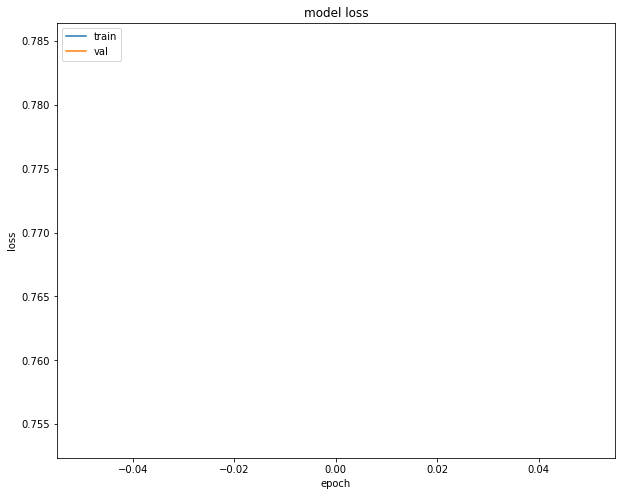

In [33]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
import h5py
desk_net.load_weights('checkpointed_weights_desk.hdf5')
test_data = np.load(open('bottleneck_features_test.npy'))

In [35]:
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
    
def kernel(x, y):
    return desk_net.predict([x, y])[:, 0]

def compute_kernel(X, Y):
    n1, n2 = X.shape[0], Y.shape[0]
    columns = [np.array([x] * n2) for x in X]    
    dot_products =[kernel(col, Y) for col in columns]
    return np.vstack(dot_products)

In [36]:
%%time
n_samples = 2000
train_examples = train_data[0: n_samples]
train_kernel = compute_kernel(train_examples, train_examples)

CPU times: user 108 ms, sys: 4 ms, total: 112 ms
Wall time: 99.8 ms


In [37]:
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel, y_train[:n_samples])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto',
  kernel='precomputed', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [38]:
y_train_pred = clf.predict(train_kernel)
y_train_true = y_train[: n_samples]
print(accuracy_score(y_train_true, y_train_pred))
print(confusion_matrix(y_train_true, y_train_pred))

0.5
[[ 0 10]
 [ 0 10]]


In [42]:
%%time
n = 2000
test_kernel = compute_kernel(test_data[:n], train_examples)
y_pred = clf.predict(test_kernel)

CPU times: user 4.22 s, sys: 576 ms, total: 4.8 s
Wall time: 3.94 s


In [40]:
y_true = y_test[:n]

In [41]:
print(accuracy_score(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

0.6
[[0 4]
 [0 6]]
